# This notebook submits results to the DPhi challenge: https://dphi.tech/challenges/data-sprint-90-bar-passage-qualification/295/submit

# Methodology:
1. Drop redundant and duplicate columns
2. Balancing of dataset using minority oversampling
3. Cross validation for selecting good models for finetuning
4. Gridsearch CV for selecting best hyperparameters

# Import all libraries required

In [192]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score as acc, classification_report as cr, ConfusionMatrixDisplay as cm
from sklearn.metrics import precision_score as ps, recall_score as rs, f1_score as f1
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Declare the path

In [193]:
train_path = '/home/sandeep/Development/Datasets/Education/Dphi_DS90_Bar_Passage_Qualification/data/train_dataset.csv'
test_path = '/home/sandeep/Development/Datasets/Education/Dphi_DS90_Bar_Passage_Qualification/data/test_dataset.csv'

# Read the csv datasets into pandas dataframes

In [194]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
display(train_df.head(1))
display(test_df.head(1))

,decile3,decile1,sex,lsat,ugpa,grad,fulltime,fam_inc,parttime,male,race1,tier,decile1b,pass_bar
0,9.0,8.0,1.0,40.0,3.7,0,1.0,4.0,0.0,0.0,4,4.0,8.0,1


,decile3,decile1,sex,lsat,ugpa,grad,fulltime,fam_inc,parttime,male,race1,tier,decile1b
0,5.0,4.0,1.0,29.0,3.1,0,1.0,3.0,0.0,0.0,4,3.0,3.0


# Check unique values in columns

In [195]:
for i in test_df.columns:
    n = train_df[i].nunique()
    m = test_df[i].nunique()
    print(f'Feature {i} has {n} in train and {m} in test')

Feature decile3 has 10 in train and 10 in test
Feature decile1 has 10 in train and 10 in test
Feature sex has 2 in train and 2 in test
Feature lsat has 90 in train and 89 in test
Feature ugpa has 23 in train and 22 in test
Feature grad has 1 in train and 1 in test
Feature fulltime has 2 in train and 2 in test
Feature fam_inc has 5 in train and 5 in test
Feature parttime has 2 in train and 2 in test
Feature male has 2 in train and 2 in test
Feature race1 has 5 in train and 5 in test
Feature tier has 6 in train and 6 in test
Feature decile1b has 10 in train and 10 in test


# Grad column is useless, drop it

In [196]:
train_df.drop('grad',axis=1,inplace=True)
test_df.drop('grad',axis=1,inplace=True)

# Columns parttime/fulltime, male/sex are duplicates, drop one from each

In [197]:
train_df.drop(['male','parttime'],axis=1,inplace=True)
test_df.drop(['male','parttime'],axis=1,inplace=True)

# Separate into dependent and independent features

In [198]:
train_X = train_df.drop(['pass_bar'], axis=1).copy()
train_y = train_df.pass_bar.copy()
final_X = test_df.copy()

# Visualize the features data

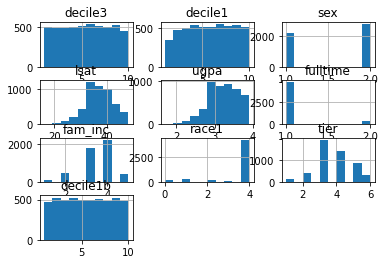

In [199]:
train_X.hist()
plt.show()

# Visualize the dependent data

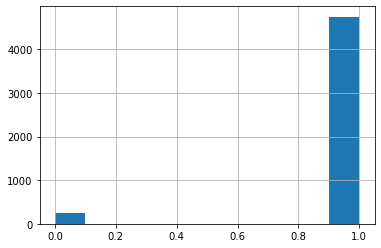

In [200]:
train_y.hist()
plt.show()

# The target classes are imbalanced, bar exam failed cases are a small fraction of that of passed ones

# Let's balance the data by carrying out minority oversampling

In [201]:
sm = SMOTE()
X, y = sm.fit_resample(train_X, train_y)

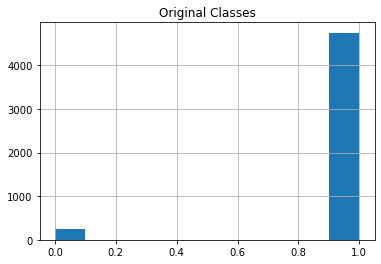

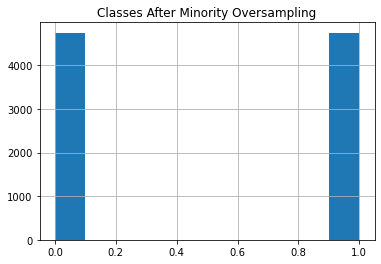

In [202]:
train_y.hist()
plt.title('Original Classes')
plt.show()
y.hist()
plt.title('Classes After Minority Oversampling')
plt.show()

# Train Test Split

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Cross Validation for model selection

# Define the models for classification

In [204]:
models = {'LOG': LogisticRegression(max_iter=500, solver='liblinear'),
         'LDA': LinearDiscriminantAnalysis(),
         'KNN': KNeighborsClassifier(),
         'GNB': GaussianNB(),
         'DCT': DecisionTreeClassifier(),
         'SVM': SVC(),
          'RFC': RandomForestClassifier(),
          'ADA': AdaBoostClassifier(),
         'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        }

# Evaluate each model in turn using cross validation score on the training data. Metrics: Accuracy, Precision, Recall, F1 Score

In [205]:
for name, model in models.items():
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'])
    print(f"{name}: Acc: {cv_results['test_accuracy'].mean():.3f},\
Prec: {cv_results['test_precision'].mean():.3f}, Rec: {cv_results['test_recall'].mean():.3f}, \
F1: {cv_results['test_f1'].mean():.3f}")

LOG: Acc: 0.820,Prec: 0.842, Rec: 0.787, F1: 0.814
LDA: Acc: 0.818,Prec: 0.867, Rec: 0.753, F1: 0.806
KNN: Acc: 0.907,Prec: 0.991, Rec: 0.822, F1: 0.898
GNB: Acc: 0.791,Prec: 0.829, Rec: 0.734, F1: 0.778
DCT: Acc: 0.945,Prec: 0.948, Rec: 0.942, F1: 0.945
SVM: Acc: 0.816,Prec: 0.857, Rec: 0.759, F1: 0.805
RFC: Acc: 0.972,Prec: 0.969, Rec: 0.974, F1: 0.972
ADA: Acc: 0.926,Prec: 0.925, Rec: 0.927, F1: 0.926
XGB: Acc: 0.968,Prec: 0.959, Rec: 0.977, F1: 0.968


# Random Forest and XGB Classifiers are good contenders for finetuning and predictions

# After GridsearchCV, selected XGBoost Classifier for final predictions

In [206]:
Params= {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 
         'booster': 'gbtree', 'colsample_bylevel': 0, 'colsample_bynode': 0, 'colsample_bytree': 0, 
         'enable_categorical': False, 'gamma': 0.0, 'gpu_id': -1, 'importance_type': None, 
         'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 
         'min_child_weight': 0.5, 'n_estimators': 500, 
         'n_jobs': 4, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 
         'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 
         'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'}

In [207]:
model = XGBClassifier(**Params      )
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(f'Acc: {acc(y_test, preds):0.4f}, Prec: {ps(y_test, preds):0.4f},\
Rec: {rs(y_test, preds):0.4f}, F1: {f1(y_test, preds):0.4f}')

Acc: 0.9779, Prec: 0.9642,Rec: 0.9926, F1: 0.9782


# Feature Importances

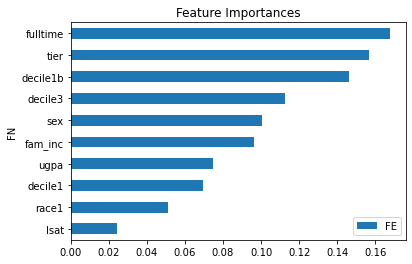

In [208]:
ax = pd.DataFrame(sorted(list(zip(model.feature_importances_, train_X.columns)), 
                        key=lambda x:x[0]), columns=['FE', 'FN'])
ax.set_index('FN', inplace=True)
ax.plot(kind='barh', title='Feature Importances')
plt.show()

# Confusion Matrix

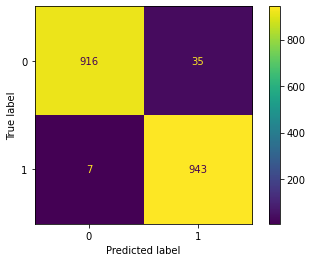

In [209]:
cm.from_predictions(y_test, preds)
plt.show()

# Classification Report

In [210]:
print(cr(y_test,preds))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       951
           1       0.96      0.99      0.98       950

    accuracy                           0.98      1901
   macro avg       0.98      0.98      0.98      1901
weighted avg       0.98      0.98      0.98      1901



# Predictions

In [211]:
final_preds = pd.DataFrame(model.predict(final_X), columns=['pass_bar'])
final_preds.to_csv('/home/sandeep/Development/Datasets/Education/Dphi_DS90_Bar_Passage_Qualification/submission/sub.csv', 
                   index=False)